<a href="https://colab.research.google.com/github/PariSharma-commits/Terrier-using_Kaggle_dataset_on_flight_simulation-/blob/main/Terrier_trainedOnKaggleData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy scikit-learn matplotlib


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("datasetengineer/surveildrone-net23")

print("Path to dataset files:", path)
import pandas as pd
import os

# Step 2: see which files got downloaded
print("Files in dataset folder:", os.listdir(path))

# Step 3: load the actual CSV
df = pd.read_csv(os.path.join(path, "SurveilDrone-Net23.csv"))

# Step 4: peek at data
print(df.head())
print(df.columns)


Path to dataset files: /kaggle/input/surveildrone-net23
Files in dataset folder: ['SurveilDrone-Net23.csv']
             timestamp mission_id drone_id  altitude_m  velocity_x  \
0  2021-01-01 00:00:00    MSN2824      DR2          56   -3.003620   
1  2021-01-01 00:15:00    MSN1409      DR3         112    0.898677   
2  2021-01-01 00:30:00    MSN5506      DR6          87   -1.642041   
3  2021-01-01 00:45:00    MSN5012      DR7          74    0.041976   
4  2021-01-01 01:00:00    MSN4657      DR6          40    6.469317   

   velocity_y  velocity_z  acceleration_x  acceleration_y  acceleration_z  \
0    1.745126   -1.012630       -0.116718        0.654640        0.591926   
1   -6.052608    0.084181       -0.491444       -1.160391       -0.987538   
2    0.605855   -2.683689        0.410175       -1.378734       -0.958764   
3   -2.872027    0.718481        0.454186       -0.609361       -1.890276   
4    0.043959    0.361757       -0.710856       -2.772141        0.371007   

   ...  

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Step 1: pick numeric columns for anomaly detection
numeric_cols = [
    'altitude_m', 'velocity_x', 'velocity_y', 'velocity_z',
    'acceleration_x', 'acceleration_y', 'acceleration_z',
    'heading_deg', 'distance_to_base_m', 'battery_level_pct',
    'power_consumption_watts', 'flight_time_s',
    'hover_duration_s', 'ambient_temp_C', 'wind_speed_mps',
    'proximity_to_restricted_zone_m', 'detected_object_count',
    'average_object_size_px', 'thermal_signature_intensity',
    'detection_confidence_avg'
]

df_numeric = df[numeric_cols].dropna()

# Step 2: scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# Step 3: train Isolation Forest
iso = IsolationForest(contamination=0.05, random_state=42)  # 5% anomalies
df['anomaly_flag'] = iso.fit_predict(X_scaled)

# Step 4: convert anomaly flag to human-readable labels
# IsolationForest gives: -1 = anomaly, 1 = normal
df['anomaly_flag'] = df['anomaly_flag'].map({1: 'normal', -1: 'anomaly'})

# Step 5: preview
print(df[['timestamp', 'drone_id', 'altitude_m', 'battery_level_pct', 'anomaly_flag']].head(20))

# Step 6: save output so teammate can graph
df.to_csv("SurveilDrone_with_anomalies.csv", index=False)
print("Saved enriched dataset as SurveilDrone_with_anomalies.csv")


              timestamp drone_id  altitude_m  battery_level_pct anomaly_flag
0   2021-01-01 00:00:00      DR2          56                 20       normal
1   2021-01-01 00:15:00      DR3         112                 29       normal
2   2021-01-01 00:30:00      DR6          87                 38       normal
3   2021-01-01 00:45:00      DR7          74                 18       normal
4   2021-01-01 01:00:00      DR6          40                 22      anomaly
5   2021-01-01 01:15:00      DR9          40                 75       normal
6   2021-01-01 01:30:00      DR7          33                 43       normal
7   2021-01-01 01:45:00      DR6         102                 15       normal
8   2021-01-01 02:00:00      DR5          74                 22       normal
9   2021-01-01 02:15:00      DR8          85                 10       normal
10  2021-01-01 02:30:00      DR2          31                 15       normal
11  2021-01-01 02:45:00      DR2         115                 12       normal

In [ ]:
# Cell 4: Analyze anomaly results

# 1. Count how many anomalies per drone
anomaly_counts = df.groupby('drone_id')['anomaly_flag'].value_counts().unstack().fillna(0)
print("Anomalies per Drone:")
print(anomaly_counts)

# 2. Count how many anomalies per mission type (if present)
if 'mission_type' in df.columns:
    mission_anomalies = df.groupby('mission_type')['anomaly_flag'].value_counts().unstack().fillna(0)
    print("\nAnomalies per Mission Type:")
    print(mission_anomalies)

# 3. High-level anomaly rate
total_rows = len(df)
anomalies_total = (df['anomaly_flag'] == 'anomaly').sum()
print(f"\nTotal anomalies: {anomalies_total} out of {total_rows} ({anomalies_total/total_rows:.2%})")

# 4. Example of "when" anomalies occur
df['timestamp'] = pd.to_datetime(df['timestamp'])
anomalies_over_time = df[df['anomaly_flag'] == 'anomaly'].groupby(df['timestamp'].dt.date).size()

print("\nAnomalies per Day:")
print(anomalies_over_time.head(10))  # just first 10 days

# 5. Save just the anomalies (for plotting / teammate)
df_anomalies = df[df['anomaly_flag'] == 'anomaly']
df_anomalies.to_csv("SurveilDrone_only_anomalies.csv", index=False)
print("Saved SurveilDrone_only_anomalies.csv with flagged anomaly rows")


Anomalies per Drone:
anomaly_flag  anomaly  normal
drone_id                     
DR1               694   13435
DR10              711   13310
DR2               732   13325
DR3               742   13446
DR4               692   13173
DR5               667   13531
DR6               685   13240
DR7               727   13233
DR8               652   13166
DR9               711   13384

Anomalies per Mission Type:
anomaly_flag  anomaly  normal
mission_type                 
Circle            355    6607
Patrol           3480   66898
Return            707   13322
Scan             1089   19772
Track            1382   26644

Total anomalies: 7013 out of 140256 (5.00%)

Anomalies per Day:
timestamp
2021-01-01     4
2021-01-02    11
2021-01-03     1
2021-01-04     6
2021-01-05     4
2021-01-06     5
2021-01-07     2
2021-01-08     6
2021-01-09     1
2021-01-10     7
dtype: int64
Saved SurveilDrone_only_anomalies.csv with flagged anomaly rows


In [ ]:
# Load anomalies only
anomalies = pd.read_csv("SurveilDrone_only_anomalies.csv")

print("Anomalies shape:", anomalies.shape)
print(anomalies.head())


Anomalies shape: (7013, 35)
             timestamp mission_id drone_id  altitude_m  velocity_x  \
0  2021-01-01 01:00:00    MSN4657      DR6          40    6.469317   
1  2021-01-01 07:45:00    MSN2674      DR2          41   -2.031554   
2  2021-01-01 17:30:00    MSN5422     DR10          91   -6.706328   
3  2021-01-01 19:15:00    MSN7572      DR5          34    2.817794   
4  2021-01-02 00:45:00    MSN2489      DR9          37    4.806242   

   velocity_y  velocity_z  acceleration_x  acceleration_y  acceleration_z  \
0    0.043959    0.361757       -0.710856       -2.772141        0.371007   
1    2.302018   -2.378866        0.248721       -2.114141       -1.227497   
2    2.956406    4.553111        1.952127        0.168344        0.806808   
3    7.488895    3.991688        1.649825        0.211444        2.323144   
4   -0.863638    0.153412        2.126414       -0.535288        0.711849   

   ...  wind_dir_deg  weather_condition  region_type  \
0  ...           180            

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


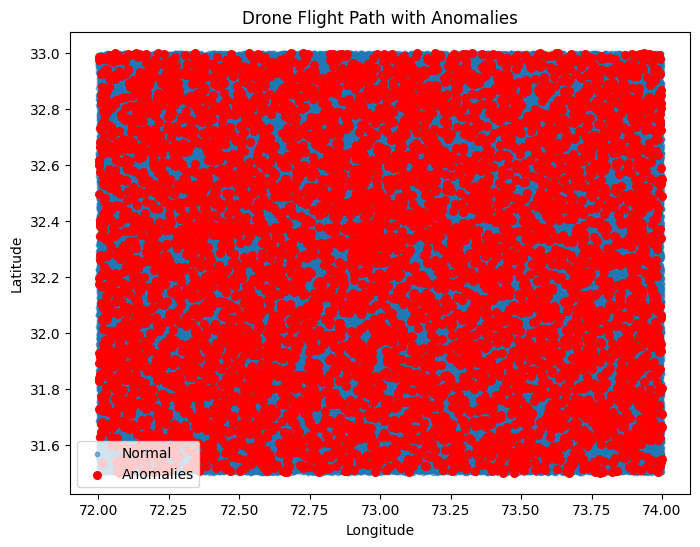

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

# normal points
plt.scatter(df['gps_lon'], df['gps_lat'], s=10, alpha=0.5, label="Normal")

# anomalies in red
plt.scatter(anomalies['gps_lon'], anomalies['gps_lat'],
            s=30, c='red', label="Anomalies")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Drone Flight Path with Anomalies")
plt.legend()
plt.show()


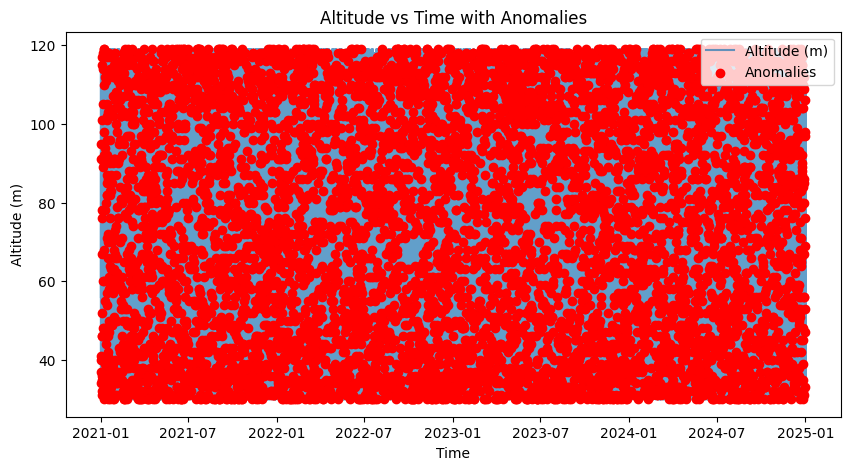

In [ ]:
plt.figure(figsize=(10,5))

# convert timestamp to datetime for plotting
df['timestamp'] = pd.to_datetime(df['timestamp'])
anomalies['timestamp'] = pd.to_datetime(anomalies['timestamp'])

plt.plot(df['timestamp'], df['altitude_m'], label="Altitude (m)", alpha=0.7)
plt.scatter(anomalies['timestamp'], anomalies['altitude_m'],
            c='red', label="Anomalies", zorder=5)

plt.xlabel("Time")
plt.ylabel("Altitude (m)")
plt.title("Altitude vs Time with Anomalies")
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


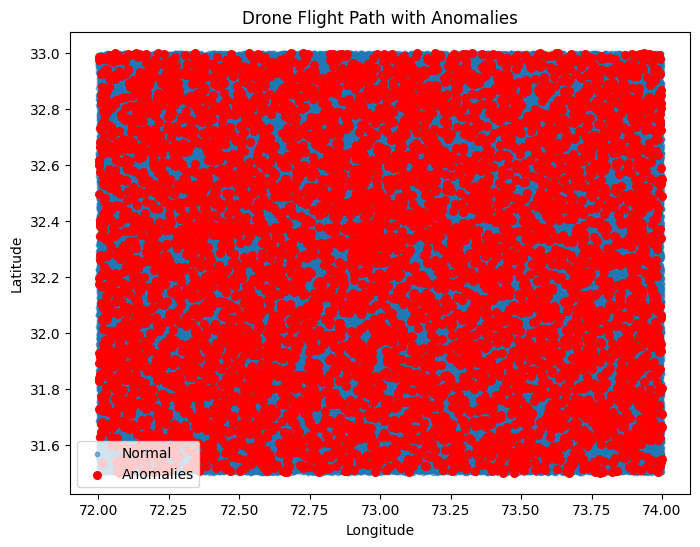

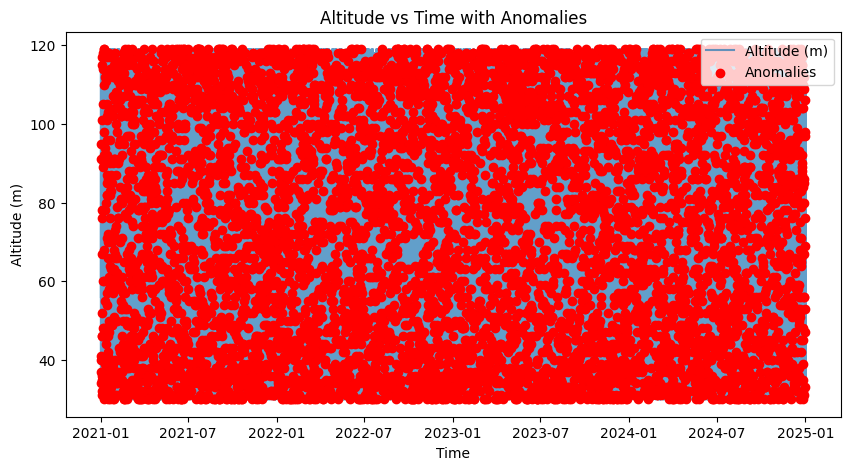

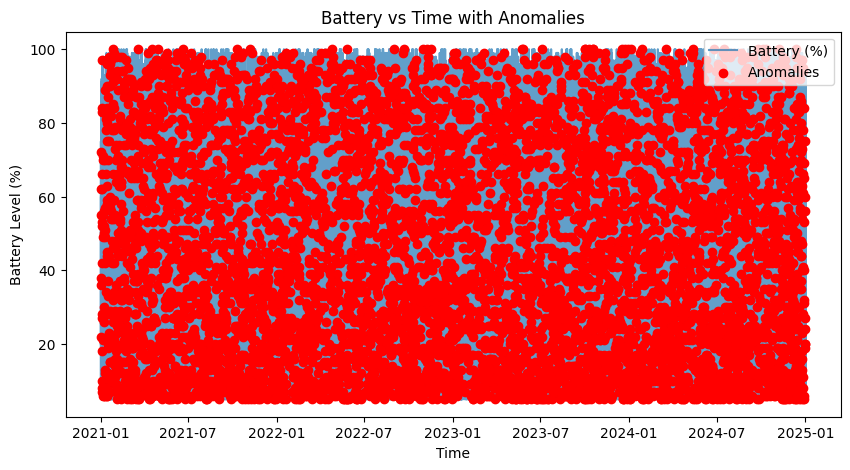

In [ ]:
import matplotlib.pyplot as plt

# Make sure timestamp is datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
anomalies['timestamp'] = pd.to_datetime(anomalies['timestamp'])

# === Plot 1: Flight Path ===
plt.figure(figsize=(8,6))
plt.scatter(df['gps_lon'], df['gps_lat'], s=10, alpha=0.5, label="Normal")
plt.scatter(anomalies['gps_lon'], anomalies['gps_lat'],
            s=30, c='red', label="Anomalies")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Drone Flight Path with Anomalies")
plt.legend()
plt.show()

# === Plot 2: Altitude vs Time ===
plt.figure(figsize=(10,5))
plt.plot(df['timestamp'], df['altitude_m'], label="Altitude (m)", alpha=0.7)
plt.scatter(anomalies['timestamp'], anomalies['altitude_m'],
            c='red', label="Anomalies", zorder=5)
plt.xlabel("Time")
plt.ylabel("Altitude (m)")
plt.title("Altitude vs Time with Anomalies")
plt.legend()
plt.show()

# === Plot 3: Battery vs Time ===
plt.figure(figsize=(10,5))
plt.plot(df['timestamp'], df['battery_level_pct'], label="Battery (%)", alpha=0.7)
plt.scatter(anomalies['timestamp'], anomalies['battery_level_pct'],
            c='red', label="Anomalies", zorder=5)
plt.xlabel("Time")
plt.ylabel("Battery Level (%)")
plt.title("Battery vs Time with Anomalies")
plt.legend()
plt.show()


In [ ]:
# === Simple text-based anomaly interpretation ===

def interpret_anomalies(df, anomalies):
    insights = []

    for _, row in anomalies.iterrows():
        ts = row['timestamp']
        msg = f"At {ts}: "

        # Check altitude
        if row['altitude_m'] < df['altitude_m'].quantile(0.05):
            msg += "⚠️ Sudden LOW altitude (possible malfunction/crash). "
        elif row['altitude_m'] > df['altitude_m'].quantile(0.95):
            msg += "⚠️ Abnormally HIGH altitude (possible diversion). "

        # Check battery
        if row['battery_level_pct'] < df['battery_level_pct'].quantile(0.05):
            msg += "⚡ Battery unusually low (possible hijack/power issue). "

        # Check GPS deviation (rough idea: far from median path)
        lon, lat = row['gps_lon'], row['gps_lat']
        if (lon < df['gps_lon'].quantile(0.05) or lon > df['gps_lon'].quantile(0.95) or
            lat < df['gps_lat'].quantile(0.05) or lat > df['gps_lat'].quantile(0.95)):
            msg += "🛰️ GPS position off expected route (possible diversion). "

        if msg == f"At {ts}: ":
            msg += "Anomaly detected but pattern unclear."

        insights.append(msg)

    return insights

# Run the interpreter
summary = interpret_anomalies(df, anomalies)

# Print first 10 anomaly insights
for line in summary[:10]:
    print(line)


At 2021-01-01 01:00:00: Anomaly detected but pattern unclear.
At 2021-01-01 07:45:00: Anomaly detected but pattern unclear.
At 2021-01-01 17:30:00: Anomaly detected but pattern unclear.
At 2021-01-01 19:15:00: Anomaly detected but pattern unclear.
At 2021-01-02 00:45:00: Anomaly detected but pattern unclear.
At 2021-01-02 06:00:00: 🛰️ GPS position off expected route (possible diversion). 
At 2021-01-02 07:45:00: 🛰️ GPS position off expected route (possible diversion). 
At 2021-01-02 09:45:00: Anomaly detected but pattern unclear.
At 2021-01-02 10:45:00: ⚠️ Abnormally HIGH altitude (possible diversion). 🛰️ GPS position off expected route (possible diversion). 
At 2021-01-02 12:15:00: ⚠️ Sudden LOW altitude (possible malfunction/crash). 
